In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf

In [36]:
data_path  = "/home/ecbm4040/preprocessed_data.csv"
df1 = pd.read_csv(data_path,names=['text','job_category'],encoding = "ISO-8859-1")
df2 = pd.read_csv('/home/ecbm4040/data_scientist_united_states_job_postings_jobspikr.csv',names=['text','job_category'],encoding = "ISO-8859-1")
df3 = pd.read_csv('/home/ecbm4040/software_developer_united_states_1971_20191023_1.csv',names=['text','job_category'],encoding = "ISO-8859-1")

In [54]:
df=pd.concat([df1,df2, df3], ignore_index = True,axis=0)
d = {'job_category':df['job_category'].value_counts().index, 'count': df['job_category'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df['cat_id'] = df['job_category'].factorize()[0]
cat_id_df = df[['job_category', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'job_category']].values)

In [55]:
MAX_NB_WORDS = 500
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100
 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index


In [56]:
X = tokenizer.texts_to_sequences(df['text'].values)
#填充X,让X的各个列的长度统一
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
 
#多类标签的onehot展开
Y = pd.get_dummies(df['cat_id']).values
 
print(X.shape)
print(Y.shape)

(9984, 250)
(9984, 27)


In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8985, 250) (8985, 27)
(999, 250) (999, 27)


In [58]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(tf.keras.layers.LSTM(50, dropout=0.2,return_sequences=True, recurrent_dropout=0.2))
model.add(tf.keras.layers.LSTM(50, dropout=0.2, recurrent_dropout=0.2))
model.add(tf.keras.layers.Dense(27, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          50000     
_________________________________________________________________
lstm_8 (LSTM)                (None, 250, 50)           30200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 27)                1377      
Total params: 101,777
Trainable params: 101,777
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/10
127/127 [==============================] - 91s 689ms/step - loss: 1.7035 - accuracy: 0.5851 - val_loss: 0.8264 - val_accuracy: 0.6085
Epoch 2/10
127/127 [==============================] - 86s 678ms/step - loss: 0.8189 - accuracy: 0.6187 - val_loss: 0.8150 - val_accuracy: 0.6107
Epoch 3/10
127/127 [==============================] - 87s 682ms/step - loss: 0.7988 - accuracy: 0.6224 - val_loss: 0.7483 - val_accuracy: 0.6808
Epoch 4/10
127/127 [==============================] - 85s 671ms/step - loss: 0.6975 - accuracy: 0.6909 - val_loss: 0.7545 - val_accuracy: 0.6830
Epoch 5/10
127/127 [==============================] - 85s 671ms/step - loss: 0.8010 - accuracy: 0.6206 - val_loss: 0.4493 - val_accuracy: 0.8643
Epoch 6/10
127/127 [==============================] - 85s 666ms/step - loss: 0.4631 - accuracy: 0.8554 - val_loss: 0.4115 - val_accuracy: 0.8821
Epoch 7/10
127/127 [==============================] - 85s 666ms/step - loss: 0.3964 - accuracy: 0.8805 - val_loss: 0.5283 - val_ac

In [52]:
def predict(text):
    seq = tokenizer.texts_to_sequences(text)
    padded = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    cat_id= pred.argmax(axis=1)[0]
    return cat_id_df[cat_id_df.cat_id==cat_id]['job_category'].values[0]


In [50]:
predict('Making the right decision is a difficult but interesting thing, you must calculate the outcome of each choice and calculate the impact of each outcome. After I took the course of probability theory and statistics in college, I became fascinating in decision making methods. This passion carried me through my education at PKU. I studied new languages including SQL')

'data scientist'

In [53]:
predict('Currently I am mainly working on back-end, such as micro-service, automated workflow and event processing pipeline, but I also have experience in deploying infrastructure as code and front-end development.')

'software design'

In [65]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

hidden_features = model.predict(X)
pca = PCA(n_components=27)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
##Variance PCA: 0.993621154832802

#Run T-SNE on the PCA features.
tsne = TSNE(n_components=2, verbose = 1)
tsne_results = tsne.fit_transform(pca_result[:5000])

Variance PCA: 0.9999999403953552
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.663s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.509674
[t-SNE] KL divergence after 1000 iterations: 0.273913


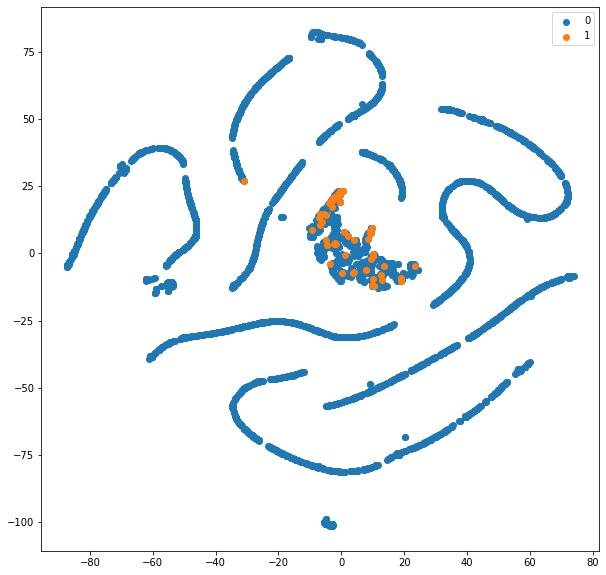

In [73]:
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

y_test_cat = to_categorical(Y[:5000], num_classes = 2)
color_map = np.argmax(y_test_cat, axis=1)
plt.figure(figsize=(10,10))
for cl in range(2):
    indices = np.where(color_map==cl)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)
plt.legend()
plt.show()